# Wordle

## Solving method

In [18]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from collections import defaultdict
import ipywidgets as widgets
from ipywidgets import interactive_output, fixed

In [19]:
with open('./data/processed/wordle-answers-alphabetical.txt', 'r') as file:
    possible_answers = file.read().splitlines() 
   
with open('./data/processed/wordle-allowed-guesses.txt', 'r') as file:
    words_allowed_guesses = file.read().splitlines() 
words_allowed_guesses = words_allowed_guesses + possible_answers

print("Number of possible answer words:", len(possible_answers))
print("Number of accepted guess words:", len(words_allowed_guesses))

Number of possible answer words: 2315
Number of accepted guess words: 12972


In [20]:
letters = [letter for letter in "azertyuiopqsdfghjklmwxcvbn"]
letter_imgs = {letter: mpimg.imread(f"letters/{letter}.png") for letter in letters}

def display_word(word):
    if word == "": return
    letters = [letter_imgs[letter] for letter in word]
    plt.figure()
    plt.imshow(np.concatenate(letters, axis=1))
    plt.axis('off')
    plt.show()

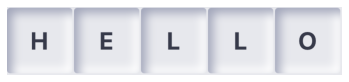

In [21]:
display_word("hello")

In [22]:
def compare_words(query_word, answer_word):
    res = []
    pos_not_found = []
    letters_not_found = []
    for (i, letter1), letter2 in zip(enumerate(query_word), answer_word):
        if letter1 == letter2:
            res.append('2')
        else:
            res.append('0')
            pos_not_found.append(i)
            letters_not_found.append(letter2)
    for i in pos_not_found:
        if query_word[i] in letters_not_found:
            res[i] = "1"
            letters_not_found.remove(query_word[i])
    return "".join(res)

In [23]:
compare_words("raise", "gorge")

'10002'

In [24]:
compare_words("crane","crane")

'22222'

In [25]:
def filter_words(possible_words, word, comparison_string):
    new_possible_words = []
    for w in possible_words:
        if compare_words(word, w) == comparison_string:
            new_possible_words.append(w)
    return new_possible_words

In [26]:
print(filter_words(possible_answers, "raise", "10002"))

['borne', 'broke', 'brute', 'chore', 'creme', 'crepe', 'crone', 'crude', 'curve', 'drone', 'drove', 'erode', 'force', 'forge', 'forte', 'froze', 'genre', 'gorge', 'grope', 'grove', 'horde', 'merge', 'nerve', 'ombre', 'probe', 'prone', 'prove', 'prude', 'prune', 'puree', 'purge', 'there', 'three', 'trope', 'trove', 'truce', 'verge', 'verve', 'where', 'wrote']


$ score(word) = \sum_{letter  \in  word}\frac{1}{rank(letter)} $

In [27]:
letters_by_frequency = "eariotnslcudpmhgbfywkvxzjq"
letters_scores = {letter: 1/(i+1) for i, letter in enumerate(letters_by_frequency)}
    
def score_RelativeFreq_ofWord(word):
    score = 0
    for letter in set(word):
        score += letters_scores[letter]
    return score

In [28]:
print("raise:", score_RelativeFreq_ofWord("raise"))
print("bumpy:", score_RelativeFreq_ofWord("bumpy"))

raise: 2.208333333333333
bumpy: 0.3507158476198724


In [30]:
def solver_RelativeFrequency_method(comparison_string, word, possible_words):
    possible_words = filter_words(possible_words, word, comparison_string)
    if len(possible_words) == 0:
        print("No possible word in vocabulary.")
        return "", []
    else:
        words_sorted = sorted(possible_words, key=score_RelativeFreq_ofWord, reverse=True)
        word = words_sorted[0]
        return word, possible_words

## Improved solving method by combining Entropy with Relative Frequency

![Score](https://raw.githubusercontent.com/suhasAB/WordleOptimizer/main/paper/images/entropy%2Brelfreq.png)

In [31]:
def score_EntropyRelFreqCombo_OfWord(query_word, possible_words):
    nb_words = len(possible_words)
    comparison_dict = defaultdict(int)
    for word in possible_words:
        comparison_dict[compare_words(query_word, word)] += 1
    return sum(word_count / nb_words * word_count for word_count in comparison_dict.values())

In [32]:
print(score_EntropyRelFreqCombo_OfWord("crane",possible_answers))

78.74168466522653


In [33]:
def best_starting_word(possible_guesses, possible_answers, topn=20):
    word_scores = []
    for word in tqdm(possible_guesses):
        word_scores.append((word, score_EntropyRelFreqCombo_OfWord(word, possible_answers)))
    word_scores = sorted(word_scores, key=lambda x: x[1])
    for i in range(topn):
        print(f"{word_scores[i][0]} : {word_scores[i][1]}")
        

In [34]:
best_starting_word(words_allowed_guesses, possible_answers,topn=20)

  0%|          | 0/12972 [00:00<?, ?it/s]

roate : 60.42462203023761
raise : 61.00086393088555
raile : 61.3308855291577
soare : 62.301079913606905
arise : 63.72570194384452
irate : 63.77926565874733
orate : 63.890712742980604
ariel : 65.28768898488111
arose : 66.02116630669536
raine : 67.05615550755918
artel : 67.49589632829363
taler : 67.73693304535621
ratel : 69.84319654427625
aesir : 69.88293736501068
arles : 69.8907127429805
realo : 69.94773218142538
alter : 69.99179265658731
saner : 70.12570194384423
later : 70.22332613390904
snare : 71.09762419006455


In [35]:
best_20_starting_words=["roate","raise","raile","soare","arise","irate","orate","ariel","arose","raine","artel","taler","ratel","aesir","arles","realo","alter","saner","later","snare"]


In [36]:
def solver_EntropyRelFreqCombo_method(comparison_string, word, possible_words):
    possible_words = filter_words(possible_words, word, comparison_string)
    if len(possible_words) == 0:
        print("No possible word in vocabulary.")
        return "", []
    else:
        words_sorted = sorted(possible_words, key=lambda x: score_EntropyRelFreqCombo_OfWord(x, possible_words))
        word = words_sorted[0]
        return word, possible_words
    
    
def solver_AdvancedEntropyRelFreqCombo_method(comparison_string, word, possible_words):
    possible_words = filter_words(possible_words, word, comparison_string)
    if len(possible_words) == 0:
        print("No possible word in vocabulary.")
        return "", []
    else:
        if len(possible_words) <= 3:
            words_sorted = sorted(possible_words, key=lambda x: score_EntropyRelFreqCombo_OfWord(x, possible_words))
        else:
            words_sorted = sorted(words_allowed_guesses, key=lambda x: score_EntropyRelFreqCombo_OfWord(x, possible_words))
        word = words_sorted[0]
        return word, possible_words

## Evalutating solutions

In [37]:
def test_solution(answer_word, solver_method_type, starting_word="tares"):
    word = starting_word
    possible_words = possible_answers
    attempts = 1
    while attempts < 20:
        if word == answer_word:
            return attempts
        attempts += 1
        comparison_string = compare_words(word, answer_word)
        word, possible_words = solver_method_type(comparison_string, word, possible_words)
    return attempts

def evaluate_solver(possible_words, solver_method_type, starting_word="mount"):
    solves = []
    for word in tqdm(possible_answers):
        solves.append((word, test_solution(word, solver_method_type, starting_word=starting_word)))
    mean_attempts = sum([solve[1] for solve in solves])/len(solves)
    print(f"Mean number of attempts: {mean_attempts} accross {len(solves)} games") 
    failed = [solve[0] for solve in solves if solve[1] > 6]
    print(f"Failed words (more than 6 attempts): {len(failed)}")
    print(", ".join(failed))

In [38]:
evaluate_solver(possible_answers, solver_EntropyRelFreqCombo_method, starting_word="raise")

  0%|          | 0/2315 [00:00<?, ?it/s]

Mean number of attempts: 3.624622030237581 accross 2315 games
Failed words (more than 6 attempts): 14
foyer, goner, graze, match, pound, shave, swore, tatty, waste, watch, water, wight, willy, wound


In [39]:
print("Evaluating Entropy+Relative Frequency method for 10 different starting words")
for word in best_20_starting_words[:10]:
    print("Starting word:- ",word)
    evaluate_solver(possible_answers,solver_EntropyRelFreqCombo_method,starting_word=word)
    print("------------------------------------------------------------------------------")

Evaluating Entropy+Relative Frequency method for 10 different starting words
Starting word:-  roate


  0%|          | 0/2315 [00:00<?, ?it/s]

Mean number of attempts: 3.5939524838012957 accross 2315 games
Failed words (more than 6 attempts): 12
goner, homer, patch, pound, sound, stash, vaunt, waste, watch, wight, willy, wound
------------------------------------------------------------------------------
Starting word:-  raise


  0%|          | 0/2315 [00:00<?, ?it/s]

Mean number of attempts: 3.624622030237581 accross 2315 games
Failed words (more than 6 attempts): 14
foyer, goner, graze, match, pound, shave, swore, tatty, waste, watch, water, wight, willy, wound
------------------------------------------------------------------------------
Starting word:-  raile


  0%|          | 0/2315 [00:00<?, ?it/s]

Mean number of attempts: 3.6168466522678187 accross 2315 games
Failed words (more than 6 attempts): 11
goner, graze, homer, joker, swore, waste, watch, wight, willy, wound, wrote
------------------------------------------------------------------------------
Starting word:-  soare


  0%|          | 0/2315 [00:00<?, ?it/s]

Mean number of attempts: 3.6375809935205186 accross 2315 games
Failed words (more than 6 attempts): 14
goner, graze, grown, jaunt, patch, shave, swore, tower, tried, vaunt, waste, watch, wight, wound
------------------------------------------------------------------------------
Starting word:-  arise


  0%|          | 0/2315 [00:00<?, ?it/s]

Mean number of attempts: 3.6280777537796975 accross 2315 games
Failed words (more than 6 attempts): 16
foyer, goner, graze, grown, pound, shape, shave, swore, tatty, taunt, vaunt, waste, watch, wight, willy, wound
------------------------------------------------------------------------------
Starting word:-  irate


  0%|          | 0/2315 [00:00<?, ?it/s]

Mean number of attempts: 3.6077753779697623 accross 2315 games
Failed words (more than 6 attempts): 13
crazy, foyer, goner, patch, pound, saner, tight, vaunt, waste, watch, wight, willy, wound
------------------------------------------------------------------------------
Starting word:-  orate


  0%|          | 0/2315 [00:00<?, ?it/s]

Mean number of attempts: 3.6056155507559393 accross 2315 games
Failed words (more than 6 attempts): 17
crazy, goner, homer, jolly, mound, mover, patch, pound, rower, sound, stash, swear, vaunt, waste, watch, wight, willy
------------------------------------------------------------------------------
Starting word:-  ariel


  0%|          | 0/2315 [00:00<?, ?it/s]

Mean number of attempts: 3.6177105831533476 accross 2315 games
Failed words (more than 6 attempts): 14
foyer, goner, saner, shave, silly, sober, sower, swore, tatty, vaunt, watch, wight, willy, wound
------------------------------------------------------------------------------
Starting word:-  arose


  0%|          | 0/2315 [00:00<?, ?it/s]

Mean number of attempts: 3.6488120950323975 accross 2315 games
Failed words (more than 6 attempts): 14
goner, graze, jaunt, pound, shape, shave, swore, tatty, tower, vaunt, waste, watch, wight, wound
------------------------------------------------------------------------------
Starting word:-  raine


  0%|          | 0/2315 [00:00<?, ?it/s]

Mean number of attempts: 3.6125269978401726 accross 2315 games
Failed words (more than 6 attempts): 13
foyer, graze, homer, mover, pound, power, tatty, vaunt, waste, watch, water, willy, wound
------------------------------------------------------------------------------


In [40]:
evaluate_solver(possible_answers, solver_EntropyRelFreqCombo_method, starting_word="tares")

  0%|          | 0/2315 [00:00<?, ?it/s]

Mean number of attempts: 3.5913606911447085 accross 2315 games
Failed words (more than 6 attempts): 9
foyer, goner, jaunt, pound, shave, stash, tatty, watch, wound


In [41]:
evaluate_solver(possible_answers, solver_EntropyRelFreqCombo_method, starting_word="crane")

  0%|          | 0/2315 [00:00<?, ?it/s]

Mean number of attempts: 3.5779697624190065 accross 2315 games
Failed words (more than 6 attempts): 10
crazy, foyer, jolly, pound, shave, vaunt, waste, watch, willy, wound


In [42]:
test_solution("alone",solver_EntropyRelFreqCombo_method,starting_word="crane")

2

In [46]:
test_solution("alone",solver_AdvancedEntropyRelFreqCombo_method,starting_word="crane")

2

In [47]:
evaluate_solver(possible_answers,solver_AdvancedEntropyRelFreqCombo_method,starting_word="roate")

  0%|          | 0/2315 [00:00<?, ?it/s]

Mean number of attempts: 3.508855291576674 accross 2315 games
Failed words (more than 6 attempts): 0



In [3]:
!jupyter nbconvert 02_Entropy+RelativeFrequencyMethod-SuhasAnand.ipynb --to python

[NbConvertApp] Converting notebook 02_Entropy+RelativeFrequencyMethod-SuhasAnand.ipynb to python
[NbConvertApp] Writing 7520 bytes to 02_Entropy+RelativeFrequencyMethod-SuhasAnand.py
